# Energy Efficiency Regression using PyTorch, XGBoost, and ONNX
UCI Energy Efficiency Dataset

In [1]:
!pip install xgboost skl2onnx onnxmltools onnxruntime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



from xgboost import XGBRegressor
import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


## Load UCI Energy Efficiency Dataset

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)
df = df.rename(columns=lambda x: x.strip())
print(df.shape)
df.head()

(768, 10)


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## Select Features and Target

In [4]:
numeric_cols = ["X1","X2","X3","X4","X5","X6","X7","X8"]
target_col = "Y1"
df_model = df[numeric_cols + [target_col]].copy()
df_model.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


## Correlation Heatmap

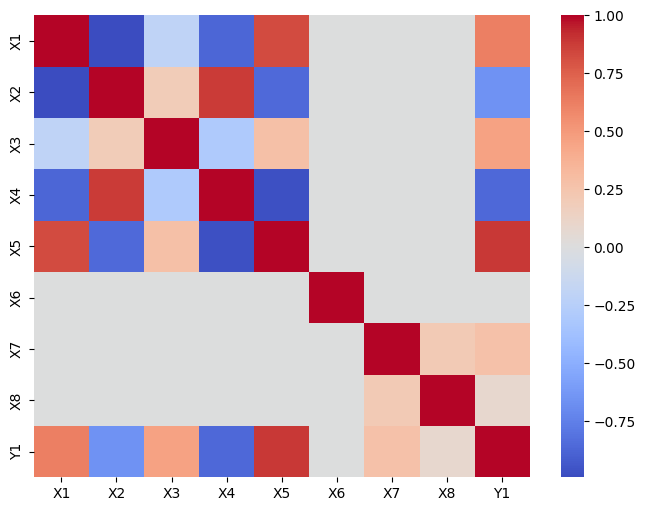

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(df_model.corr(), annot=False, cmap='coolwarm')
plt.show()

## Train/Test Split

In [6]:
X = df_model[numeric_cols].values.astype(np.float32)
y = df_model[target_col].values.astype(np.float32).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

x_means = X_train_tr.mean(0)
x_stds = X_train_tr.std(0)
x_stds[x_stds==0]=1

train_dl = DataLoader(TensorDataset(X_train_tr,y_train_tr),batch_size=32,shuffle=True)
n_features = X_train_tr.shape[1]

## PyTorch Models

In [7]:
class LinRegNet(nn.Module):
    def __init__(self,xm,xs,n):
        super().__init__()
        self.register_buffer("xm",xm)
        self.register_buffer("xs",xs)
        self.l=nn.Linear(n,1)
    def forward(self,x):
        return self.l((x-self.xm)/self.xs)

class MLP_Net(nn.Module):
    def __init__(self,xm,xs,n):
        super().__init__()
        self.register_buffer("xm",xm)
        self.register_buffer("xs",xs)
        self.l1=nn.Linear(n,32)
        self.l2=nn.Linear(32,1)
    def forward(self,x):
        x=(x-self.xm)/self.xs
        return self.l2(torch.relu(self.l1(x)))

class DL_Net(nn.Module):
    def __init__(self,xm,xs,n):
        super().__init__()
        self.register_buffer("xm",xm)
        self.register_buffer("xs",xs)
        self.l1=nn.Linear(n,64)
        self.l2=nn.Linear(64,32)
        self.l3=nn.Linear(32,1)
    def forward(self,x):
        x=(x-self.xm)/self.xs
        x=torch.relu(self.l1(x))
        x=torch.relu(self.l2(x))
        return self.l3(x)

class LinearPlusNN(nn.Module):
    def __init__(self,xm,xs,n):
        super().__init__()
        self.register_buffer("xm",xm)
        self.register_buffer("xs",xs)
        self.lin=nn.Linear(n,1)
        self.h1=nn.Linear(n,16)
        self.h2=nn.Linear(16,1)
    def forward(self,x):
        xn=(x-self.xm)/self.xs
        return self.lin(xn) + self.h2(torch.relu(self.h1(xn)))


## Training Loop

In [8]:
def train_model(m,dl,epochs=200,lr=1e-3):
    opt=optim.Adam(m.parameters(),lr=lr)
    loss_fn=nn.MSELoss()
    losses=[]
    for e in range(epochs):
        run=0
        for xb,yb in dl:
            pred=m(xb)
            loss=loss_fn(pred,yb)
            opt.zero_grad(); loss.backward(); opt.step()
            run+=loss.item()*xb.size(0)
        losses.append(run/len(dl.dataset))
    return losses

def evaluate(m):
    m.eval()
    with torch.no_grad():
        pr_tr=m(X_train_tr).numpy()
        pr_te=m(X_test_tr).numpy()
    return r2_score(y_train,pr_tr), r2_score(y_test,pr_te)

## Train All Models

In [9]:
models={
    "Linear":LinRegNet(x_means,x_stds,n_features),
    "MLP":MLP_Net(x_means,x_stds,n_features),
    "Deep":DL_Net(x_means,x_stds,n_features),
    "LinearPlusNN":LinearPlusNN(x_means,x_stds,n_features)
}
results={}
for name,m in models.items():
    print("Training",name)
    train_model(m,train_dl)
    results[name]=evaluate(m)
results

Training Linear
Training MLP
Training Deep
Training LinearPlusNN


{'Linear': (-2.357367753982544, -2.3087973594665527),
 'MLP': (0.9258525371551514, 0.9170688986778259),
 'Deep': (0.9758498072624207, 0.9743635654449463),
 'LinearPlusNN': (0.9344087243080139, 0.9264031052589417)}

## XGBoost Model

In [20]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train, y_train.ravel())
r2_train_xgb=r2_score(y_train,xgb.predict(X_train))
r2_test_xgb=r2_score(y_test,xgb.predict(X_test))
results["XGBoost"]=(r2_train_xgb,r2_test_xgb)
results

{'Linear': (-2.357367753982544, -2.3087973594665527),
 'MLP': (0.9258525371551514, 0.9170688986778259),
 'Deep': (0.9758498072624207, 0.9743635654449463),
 'LinearPlusNN': (0.9344087243080139, 0.9264031052589417),
 'XGBoost': (0.9996387362480164, 0.9985018968582153)}

## Export Best PyTorch Model to ONNX

In [11]:
best = max(["Linear","MLP","Deep","LinearPlusNN"], key=lambda x: results[x][1])
torch_path=f"energy_{best}.onnx"
torch.onnx.export(models[best], X_test_tr[:1], torch_path,
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input":{0:"batch"},"output":{0:"batch"}},
                  opset_version=13)
torch_path

/tmp/ipython-input-1751247919.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(models[best], X_test_tr[:1], torch_path,


'energy_Deep.onnx'